![Banner](./img/AI_Special_Program_Banner.jpg)

# Clustering exercise
---

In this exercise, you are to carry out a cluster analysis of a bank's marketing data. The analysis has some not insignificant **weaknesses**, which you should subsequently identify and rectify. This means that in this document you will **first** see a "*brute force*" approach using the KMeans algorithm. Your task will then be to find a **better and more robust way** to cluster the available data. The tasks in <span style="color:blue">blue</span> color can be found at the end of the document.

At the beginning there is an explanation of the scenario and the available data.

## Scenario

In this scenario, the bank has to meet stricter capital requirements and must therefore increase the proportion of long-term deposits. This was achieved with an outbound marketing campaign.

The bank wants to know if its marketing leads can be categorized into meaningful clusters to reduce the cost of the marketing campaigns or increase their effectiveness in the future. Key questions could be: "Which customer segment could be targeted more effectively?" or "What differences are there between the segments?"

## Data
The data set is based on real bank data from a Portuguese banking institution. The marketing campaigns were based on phone calls. The version we use for this analysis has fewer features (*features*) and observations to make the analysis slightly faster and easier. Further information on the data can be found in:

>[Moro et al., 2011](http://hdl.handle.net/1822/14838) S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

The data is provided by [UCI](https://archive.ics.uci.edu/ml/datasets/bank+marketing). There you will also find the following explanations of the features:

### About the features:

**bank client data:**
* job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services")
* education (categorical: "unknown","secondary","primary","tertiary")
* default: has credit in default? (binary: "yes","no")
* balance: average yearly balance, in euros (numeric)
* housing: has housing loan? (binary: "yes","no")
* loan: has personal loan? (binary: "yes","no")

**other attributes:**
* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
* poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
* deposit - has the client subscribed a term deposit? (binary: "yes" (1), "no" (2))

## Cluster analysis with k-means
---

As already mentioned, this analysis makes a few *fundamental mistakes* in some places, which you should identify and correct.

### 1. Importing the data
First, we import the known libraries that we need for the analysis. Then we import the data from the file `data/bank_marketing.csv` as Pandas DataFrame.

In [2]:
from platform import python_version

print(python_version())

3.10.12


In [3]:
!pip install ydata_profiling

In [4]:
import numpy as np
import pandas as pd 
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import sklearn.datasets as ds
%matplotlib inline

c:\Users\BJ\anaconda3\envs\aicoss\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df = pd.read_csv('data/bank_marketing.csv')
df_raw = df.copy()
df.head()

,Job,Education,Default,Balance,Housing,Loan,Campaign,Pdays,Poutcome,Deposit
0,blue-collar,secondary,no,580,yes,no,1,-1,unknown,1
1,services,secondary,no,3644,no,no,2,-1,unknown,1
2,student,tertiary,no,538,yes,no,1,-1,unknown,1
3,management,tertiary,no,1773,no,no,1,336,failure,1
4,management,tertiary,no,217,no,yes,2,-1,unknown,1


**Comment**: Unfortunately, the above description of the values of the `Deposit` column is incorrect. Instead, it contains the values 1 (meaning 'no') and 2 (meaning 'yes'):

In [3]:
df.Deposit.unique()

array([1, 2])

Strictly speaking, it would therefore be unnecessary to encode this column again (although this is done in 3.1).

### 2. Profiling

In this step, we profile the data. Real-world data can be messy, so this step should be done with care. We therefore use the image library [pandas-profiling](https://github.com/pandas-profiling/pandas-profiling).

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Job        1000 non-null   object
 1   Education  1000 non-null   object
 2   Default    1000 non-null   object
 3   Balance    1000 non-null   int64 
 4   Housing    1000 non-null   object
 5   Loan       1000 non-null   object
 6   Campaign   1000 non-null   int64 
 7   Pdays      1000 non-null   int64 
 8   Poutcome   1000 non-null   object
 9   Deposit    1000 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [5]:
profile = ProfileReport(df, title='Profile Report', minimal=True)

In [6]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 3. Transformation

In this step, we transform the data so that we can work with two explanatory variables that can explain the majority of the variance. As part of the transformation processes, we will **encode**, **scale** and perform **principal component analysis** (**PCA**).

The following **resources** will help you to familiarize yourself with the topic:

* On the importance of scaling, see the following [discussion](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813)
* Explanation of coding and scaling from [scikit-learn](https://scikit-learn.org/stable/modules/preprocessing.html)
* Very good explanation of PCA in the [video](https://www.youtube.com/watch?v=FgakZw6K1QQ) by Josh Starmer

#### 3.1 Encoding

There are many categorical variables in this data set. These must be encoded for clustering. We use the simple [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) from `scikit-learn` for this purpose. *Note:* This is actually only intended for encoding the label and not for values of the feature matrix (see documentation).

To interpret the results, a ***mapping*** is also carried out for the encoded data (using `dictionary`).

In [6]:
from sklearn.preprocessing import LabelEncoder

List of categorical variables:

In [8]:
categorical = ['Job','Education','Default','Housing','Loan', 'Poutcome','Deposit']

Coding of the variables and creation of a mapping dictionary:

In [9]:
le_name_mapping = {}
le = LabelEncoder()
for x in categorical:
    le.fit(df[x])
    le_name_mapping[x] = dict(zip(le.transform(le.classes_),le.classes_))
    df[x] = le.transform(df[x])

Check whether the coding has worked:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Job        1000 non-null   int64
 1   Education  1000 non-null   int64
 2   Default    1000 non-null   int64
 3   Balance    1000 non-null   int64
 4   Housing    1000 non-null   int64
 5   Loan       1000 non-null   int64
 6   Campaign   1000 non-null   int64
 7   Pdays      1000 non-null   int64
 8   Poutcome   1000 non-null   int64
 9   Deposit    1000 non-null   int64
dtypes: int64(10)
memory usage: 78.2 KB


Check whether the mapping dictionary works:

In [11]:
le_name_mapping['Job']

{0: 'admin',
 1: 'blue-collar',
 2: 'entrepreneur',
 3: 'housemaid',
 4: 'management',
 5: 'retired',
 6: 'self-employed',
 7: 'services',
 8: 'student',
 9: 'technician',
 10: 'unemployed',
 11: 'unknown'}

In [12]:
le_name_mapping['Deposit']

{0: 1, 1: 2}

#### 3.2 Scaling

This is an extremely important step in data preparation for clustering!

In [7]:
from sklearn.preprocessing import StandardScaler

In [14]:
stdsc = StandardScaler()
bd_sc = stdsc.fit_transform(df)

In [15]:
bd_sc[:5]

array([[-0.96617881, -0.30273701, -0.0776931 , -0.30610831,  0.92668013,
        -0.40347329, -0.62788265, -0.42819778,  0.45396197, -0.38141234],
       [ 0.87241074, -0.30273701, -0.0776931 ,  0.8010134 , -1.07912101,
        -0.40347329, -0.2757331 , -0.42819778,  0.45396197, -0.38141234],
       [ 1.17884233,  1.0427608 , -0.0776931 , -0.32128426,  0.92668013,
        -0.40347329, -0.62788265, -0.42819778,  0.45396197, -0.38141234],
       [-0.04688403,  1.0427608 , -0.0776931 ,  0.12496094, -1.07912101,
        -0.40347329, -0.62788265,  2.72678607, -2.51310971, -0.38141234],
       [-0.04688403,  1.0427608 , -0.0776931 , -0.43727188, -1.07912101,
         2.4784788 , -0.2757331 , -0.42819778,  0.45396197, -0.38141234]])

#### 3.3 Principal component analysis (PCA)

The aim is to find the components that contribute most to explaining the variance.

In [8]:
from sklearn.decomposition import PCA

Cumulative plot showing the explained variance with each additional principal component:

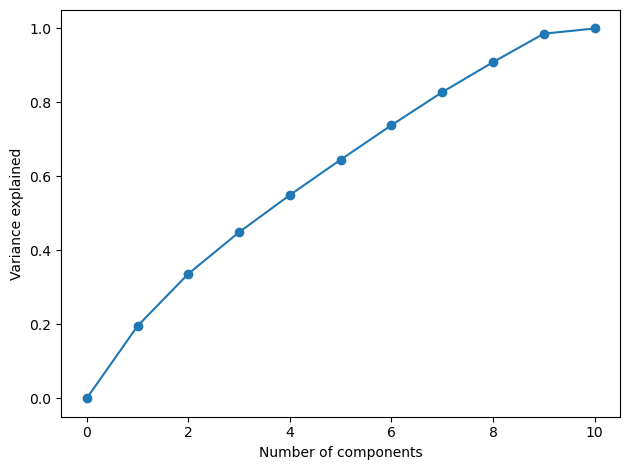

In [17]:
n_comp = len(df.columns)
pca_reducer = PCA(n_components=n_comp)
pca_reducer.fit(bd_sc)

plt.plot(range(0,n_comp+1), np.cumsum(np.insert(pca_reducer.explained_variance_ratio_, 0, 0)) , marker='o')
plt.xlabel('Number of components')
plt.ylabel('Variance explained')
plt.tight_layout()
plt.show()

For the rest of the analysis, we will keep the two most important components for the sake of visualization:

In [18]:
pca_reducer = PCA(n_components=2)
reduced_data = pca_reducer.fit_transform(bd_sc)

In [19]:
reduced_data[:5]

array([[-0.24495813, -1.21961949],
       [-0.81436263,  0.78346663],
       [-0.46924597,  0.33230119],
       [ 3.3439827 ,  1.31907659],
       [-0.99460246,  0.13350728]])

In [20]:
reduced_data.shape

(1000, 2)

How much variance is covered with just two components?

In [21]:
print(f'Variance % for 1st component: {pca_reducer.explained_variance_ratio_[0]}')
print(f'Variance % for 2nd component: {pca_reducer.explained_variance_ratio_[1]}')
print(f'Total Variance explained: {sum(pca_reducer.explained_variance_ratio_)}')

Variance % for 1st component: 0.19545987528450937
Variance % for 2nd component: 0.14112240127344516
Total Variance explained: 0.33658227655795453


### 4. Clustering and visualization

Now we want to perform a clustering with the optimum number of clusters. It may be that this optimal number is not entirely clear, so it may make sense to try out more than one possibility. We also want to visualize our results in a suitable way.

In [9]:
from sklearn.cluster import KMeans

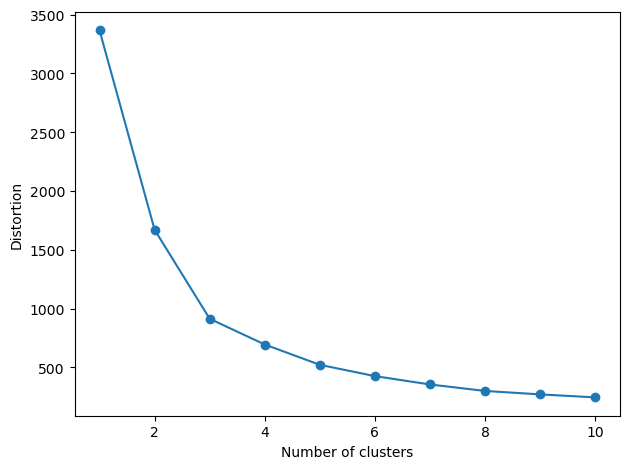

In [23]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(reduced_data)
    distortions.append(km.inertia_)
plt.plot(range(1,11), distortions , marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

The steepest decline in distortion can be observed until the number of clusters reaches 3. It might therefore be reasonable to choose 2 or 3 as the optimal number of clusters. We therefore test and interpret below for $k=2$ and $k=3$ in order to arrive at a suitable characterization of the clusters found.

#### Implementation of clustering

Here we will try 2 and 3 as the optimal number of clusters, look at the results and draw a conclusion based on the findings from the previous run(s).

Calculation of KMeans for $k=2$ and $k=3$:

In [24]:
km_2 = KMeans(n_clusters=2, n_init=10, random_state=8)
km_3 = KMeans(n_clusters=3, n_init=10, random_state=8)

cluster_2 = km_2.fit_predict(reduced_data)
cluster_3 = km_3.fit_predict(reduced_data)

In [25]:
cluster_2.shape

(1000,)

In [26]:
cluster_2[:100]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0], dtype=int32)

**Plot** of the two cluster approaches:

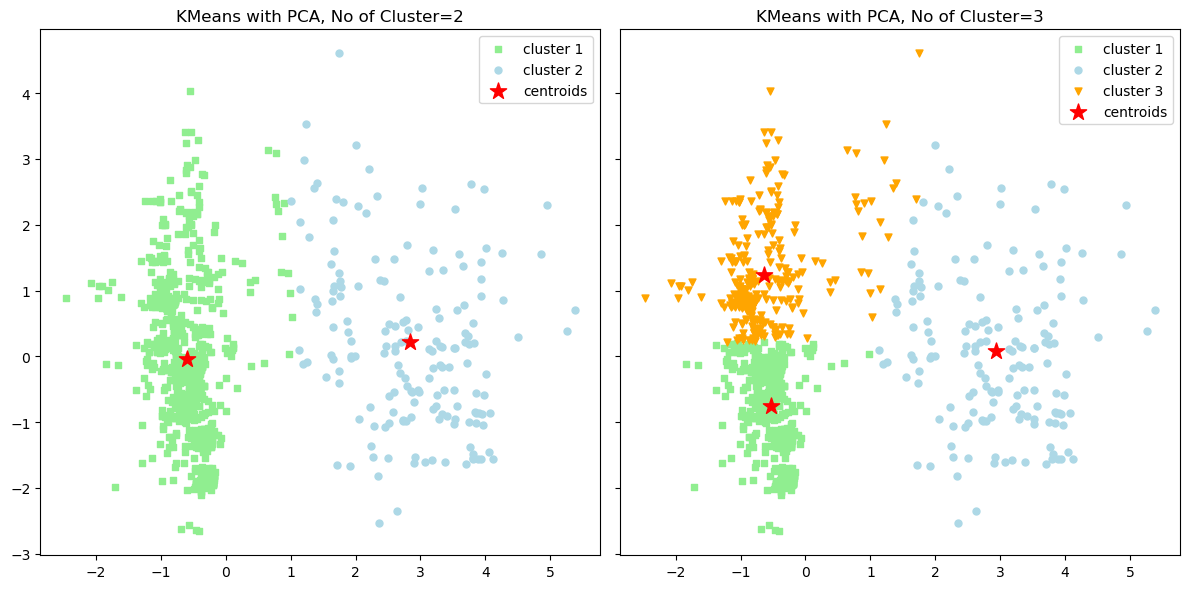

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6), sharey=True)

# Cluster mit k = 2
ax1.scatter(reduced_data[cluster_2==0, 0], reduced_data[cluster_2==0, 1], 
            s=25, 
            c='lightgreen', 
            marker='s', 
            label='cluster 1'
)
ax1.scatter(reduced_data[cluster_2==1, 0], reduced_data[cluster_2==1, 1], 
            s=25, 
            c='lightblue', 
            marker='o', 
            label='cluster 2'
)
ax1.scatter(km_2.cluster_centers_[:,0], 
            km_2.cluster_centers_[:,1], 
            s=150, 
            marker='*', 
            c='red', 
            label='centroids')
ax1.set_title('KMeans with PCA, No of Cluster=2')
ax1.legend()

# Cluster mit k=3
ax2.scatter(reduced_data[cluster_3==0, 0], reduced_data[cluster_3==0, 1], 
            s=25, 
            c='lightgreen', 
            marker='s', 
            label='cluster 1'
)
ax2.scatter(reduced_data[cluster_3==1, 0], reduced_data[cluster_3==1, 1], 
            s=25, 
            c='lightblue', 
            marker='o', 
            label='cluster 2'
)

ax2.scatter(reduced_data[cluster_3==2, 0], reduced_data[cluster_3==2, 1], 
            s=25, 
            c='orange', 
            marker='v', 
            label='cluster 3'
)
ax2.scatter(km_3.cluster_centers_[:,0], 
            km_3.cluster_centers_[:,1], 
            s=150, 
            marker='*', 
            c='red', 
            label='centroids')

ax2.set_title('KMeans with PCA, No of Cluster=3')
ax2.legend()
plt.tight_layout()
plt.show()

Visually, the solution with 2 clusters looks appealing. The cluster on the left appears to be densely populated, while the cluster on the right is sparsely populated.

In [28]:
km_3.cluster_centers_

array([[-0.52900187, -0.75800776],
       [ 2.93171355,  0.07309719],
       [-0.64112564,  1.23093043]])

**Applying the clustering to the original data:** This is easy to achieve, as the array `cluster_2` (or `cluster_3`) contains the cluster labels for the various data rows read in, i.e.:

In [29]:
cluster_2

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [30]:
df[cluster_2==1].head(10)

,Job,Education,Default,Balance,Housing,Loan,Campaign,Pdays,Poutcome,Deposit
3,4,2,0,1773,0,0,1,336,0,0
11,1,1,0,65,1,0,1,370,0,0
13,4,2,0,883,1,0,2,106,0,1
14,4,2,0,640,0,0,4,213,0,0
16,1,1,0,247,1,1,1,352,0,0
19,4,2,0,5437,0,0,1,91,0,1
22,1,1,0,-755,1,1,1,337,0,0
30,5,1,0,728,0,0,2,110,0,0
44,1,0,0,1309,1,0,2,364,0,0
50,4,1,0,453,1,0,1,269,0,0


### 5. Analysis and interpretation

Finally, we interpret our results by applying the clustering to the original data and characterizing the clusters based on typical values of the contained data.

Auxiliary function:

In [31]:
def print_categorical(cat, *limit):
    amount_list = []
    for key in le_name_mapping[cat]:
        amount_list.append([custclust.loc[custclust[cat] == key].shape[0], 
                            f"{custclust.loc[custclust[cat] == key].shape[0]/custclust.shape[0]:.0%}", 
                            le_name_mapping[cat][key]])
        amount_list.sort()
        amount_list.reverse()
    if not limit:
        print(f'{cat}: {amount_list}')
    else:
        print(f'{cat}: {amount_list[0:limit[0]]}')        

**Interpretation with k=2**

In [32]:
for i in range(0,2):
    custclust = df[cluster_2==i]
    print("Cluster {:d}".format(i+1))
    print_categorical('Job',4)
    print_categorical('Education')
    print_categorical('Default')
    print("Average Balance in cluster {:d}: {}".
          format(i+1,round(np.array(custclust['Balance']).mean(),2)))
    print_categorical('Housing')
    print_categorical('Loan')
    print("Average Campaign in cluster {:d}: {}".
          format(i+1,round(np.array(custclust['Campaign']).mean(),2)))
    print("Average Pdays in cluster {:d}: {}".
          format(i+1,round(np.array(custclust['Pdays']).mean(),2)))
    print_categorical('Poutcome',3)
    print('----')
    print("In cluster {:d} we have {} leads".format(i+1,custclust.shape[0]))
    print("Of those leads, {} made a deposit and {} did not. Ratio: {}".
          format(custclust.loc[(custclust['Deposit'] == 1)].shape[0], 
                 custclust.loc[(custclust['Deposit'] == 0)].shape[0],
                round(custclust.loc[(custclust['Deposit'] == 1)].shape[0]/custclust.shape[0],3)))
    if i != 2: print('\n')

Cluster 1
Job: [[189, '23%', 'blue-collar'], [185, '22%', 'management'], [127, '15%', 'technician'], [94, '11%', 'admin']]
Education: [[435, '53%', 'secondary'], [233, '28%', 'tertiary'], [121, '15%', 'primary'], [38, '5%', 'unknown']]
Default: [[821, '99%', 'no'], [6, '1%', 'yes']]
Average Balance in cluster 1: 1364.79
Housing: [[418, '51%', 'yes'], [409, '49%', 'no']]
Loan: [[706, '85%', 'no'], [121, '15%', 'yes']]
Average Campaign in cluster 1: 2.92
Average Pdays in cluster 1: 1.45
Poutcome: [[809, '98%', 'unknown'], [18, '2%', 'success'], [0, '0%', 'other']]
----
In cluster 1 we have 827 leads
Of those leads, 90 made a deposit and 737 did not. Ratio: 0.109


Cluster 2
Job: [[41, '24%', 'blue-collar'], [40, '23%', 'management'], [26, '15%', 'technician'], [26, '15%', 'admin']]
Education: [[91, '53%', 'secondary'], [52, '30%', 'tertiary'], [25, '14%', 'primary'], [5, '3%', 'unknown']]
Default: [[173, '100%', 'no'], [0, '0%', 'yes']]
Average Balance in cluster 2: 1725.36
Housing: [[12

#### Conclusion:

For `ncl_opt=2` there are 2 different clusters. Cluster 1 contains many more leads, but with a lower deposit rate of 10.9% (compared to 21.4% for cluster 1). The work and education situation is very similar between the two clusters, but the financial situation differs. Cluster 1 has a lower average balance and a lower proportion of loans for housing and personal purposes. Pdays are also very low in cluster 1, so these customers have not been targeted by previous campaigns.

**Interpretation with k=3**

In [33]:
for i in range(0,3):
    custclust = df[cluster_3==i]
    print("Cluster {:d}".format(i+1))
    print_categorical('Job',4)
    print_categorical('Education')
    print_categorical('Default')
    print("Average Balance in cluster {:d}: {}".
          format(i+1,round(np.array(custclust['Balance']).mean(),2)))
    print_categorical('Housing')
    print_categorical('Loan')
    print("Average Campaign in cluster {:d}: {}".
          format(i+1,round(np.array(custclust['Campaign']).mean(),2)))
    print("Average Pdays in cluster {:d}: {}".
          format(i+1,round(np.array(custclust['Pdays']).mean(),2)))
    print_categorical('Poutcome',3)
    print('----')
    print("In cluster {:d} we have {} leads".format(i+1,custclust.shape[0]))
    print("Of those leads, {} made a deposit and {} did not. Ratio: {}".
          format(custclust.loc[(custclust['Deposit'] == 1)].shape[0], 
                 custclust.loc[(custclust['Deposit'] == 0)].shape[0],
                round(custclust.loc[(custclust['Deposit'] == 1)].shape[0]/custclust.shape[0],3)))
    if i != 2: print('\n')

Cluster 1
Job: [[172, '33%', 'blue-collar'], [84, '16%', 'admin'], [76, '15%', 'management'], [61, '12%', 'technician']]
Education: [[326, '62%', 'secondary'], [114, '22%', 'primary'], [77, '15%', 'tertiary'], [7, '1%', 'unknown']]
Default: [[522, '100%', 'no'], [2, '0%', 'yes']]
Average Balance in cluster 1: 959.71
Housing: [[380, '73%', 'yes'], [144, '27%', 'no']]
Loan: [[412, '79%', 'no'], [112, '21%', 'yes']]
Average Campaign in cluster 1: 2.83
Average Pdays in cluster 1: -0.55
Poutcome: [[521, '99%', 'unknown'], [3, '1%', 'success'], [0, '0%', 'other']]
----
In cluster 1 we have 524 leads
Of those leads, 13 made a deposit and 511 did not. Ratio: 0.025


Cluster 2
Job: [[41, '25%', 'blue-collar'], [37, '23%', 'management'], [26, '16%', 'admin'], [24, '15%', 'technician']]
Education: [[88, '54%', 'secondary'], [47, '29%', 'tertiary'], [24, '15%', 'primary'], [4, '2%', 'unknown']]
Default: [[163, '100%', 'no'], [0, '0%', 'yes']]
Average Balance in cluster 2: 1595.45
Housing: [[120, '

#### Conclusion:

For `ncl_opt=3`, the algorithm basically separates the former cluster 1 into two clusters (now 1 and 3; 2 remains 2). Despite the fact that these clusters look very similar visually, they have very different characteristics. The professional, educational and financial situation changes drastically between clusters 1 and 3, which seems to have a big impact on the deposit. Cluster 2 is right in between these two, with job and education having similar characteristics to cluster 1, but with a better financial situation. In a way, the clusters could be described as *\"Lower-Class\"*, *\"Middle-Class\"* and *\"Upper-Class\"*.

<h1 style="color:blue">Exercises</h1>

---

<h2 style="color:blue">1. A new measure of <em>similarity</em></h2>

The use of encoded categorical variables in this analysis is **very questionable**. Possible sources of error may lie both in the [use of PCA](https://stackoverflow.com/questions/40795141/pca-for-categorical-features) and in the [use of k-means](https://datascience.stackexchange.com/questions/22/k-means-clustering-for-mixed-numeric-and-categorical-data) itself. Both k-means and PCA assume that the Euclidean distance of the data points can be calculated. However, if we encode categorical variables using `LabelEncoder` and then calculate the Euclidean distance, this leads to completely wrong conclusions!

For categorical (nominal) variables we usually speak of *similarity measures*, whereas for metric variables we can use a *distance measure*. We must therefore use separate measures depending on the type of variable (metric, ordinal, nominal, etc.). Such a procedure is implemented by the [Gower distance](https://medium.com/analytics-vidhya/gowers-distance-899f9c4bd553). This can therefore be used for data sets with mixed variables (see also explanation [here](https://stats.stackexchange.com/a/15313)).

<h3 style="color:blue">Task 1.1</h3>

Calculate the Gower distance matrix for the original data (in `df_raw`). Use the library [gower](https://pypi.org/project/gower) for this. You must install this with Pip: `pip install gower`.

In [10]:
import gower

In [11]:
# Your solution
df_raw

,Job,Education,Default,Balance,Housing,Loan,Campaign,Pdays,Poutcome,Deposit
0,blue-collar,secondary,no,580,yes,no,1,-1,unknown,1
1,services,secondary,no,3644,no,no,2,-1,unknown,1
2,student,tertiary,no,538,yes,no,1,-1,unknown,1
3,management,tertiary,no,1773,no,no,1,336,failure,1
4,management,tertiary,no,217,no,yes,2,-1,unknown,1
...,...,...,...,...,...,...,...,...,...,...
995,technician,secondary,no,2402,yes,no,1,-1,unknown,1
996,technician,secondary,no,1066,no,no,3,-1,unknown,2
997,blue-collar,primary,no,0,no,no,2,306,failure,1
998,admin,secondary,no,4962,no,yes,1,-1,unknown,1


In [12]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Job        1000 non-null   object
 1   Education  1000 non-null   object
 2   Default    1000 non-null   object
 3   Balance    1000 non-null   int64 
 4   Housing    1000 non-null   object
 5   Loan       1000 non-null   object
 6   Campaign   1000 non-null   int64 
 7   Pdays      1000 non-null   int64 
 8   Poutcome   1000 non-null   object
 9   Deposit    1000 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [13]:
gower_matrix = gower.gower_matrix(df_raw)
gower_matrix

array([[0.        , 0.21405336, 0.20014694, ..., 0.35004961, 0.31533134,
        0.30201176],
       [0.21405336, 0.        , 0.3142003 , ..., 0.35743633, 0.20794463,
        0.11204161],
       [0.20014694, 0.3142003 , 0.        , ..., 0.44990268, 0.41547826,
        0.4021587 ],
       ...,
       [0.35004961, 0.35743633, 0.44990268, ..., 0.        , 0.46538097,
        0.45206138],
       [0.31533134, 0.20794463, 0.41547826, ..., 0.46538097, 0.        ,
        0.11331957],
       [0.30201176, 0.11204161, 0.4021587 , ..., 0.45206138, 0.11331957,
        0.        ]], dtype=float32)

In [14]:
gower_matrix.shape

(1000, 1000)

<h3 style="color:blue">Task 1.2</h3>

Find the **most similar** (Gower distance smallest) and **most dissimilar** (Gower distance largest) data points.

**Note:**
* To obtain the corresponding indices, which you then have to insert back into the DataFrame, take a look at the following [NumPy function](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html).

In [15]:
# Your solution
min_index = np.unravel_index(np.argmin(gower_matrix), gower_matrix.shape)
min_index

(0, 0)

In [42]:
temp = gower_matrix[gower_matrix > 0]
min_index2 = np.unravel_index(np.argmin(temp), temp.shape)
min_index2

(80362,)

In [40]:
# Your solution
max_index = np.unravel_index(np.argmax(gower_matrix), gower_matrix.shape)
max_index

(438, 566)

In [16]:
gower_matrix[438,566]

0.82736856

<h2 style="color:blue">2. Clustering mit K-medoids</h2>

The K-means algorithm uses the squared Euclidean distance as the distance measure of the data points. However, we cannot use this (see above) for our categorical variables. Therefore, to perform clustering based on our new Gower distance, we need to use a different algorithm. Fortunately, there is a similar algorithm that does not require Euclidean distances: [K-medoids](https://en.wikipedia.org/wiki/K-medoids). In this task, you should therefore perform a clustering with `K-medoids`. Unfortunately, this algorithm is not included in `scikit-learn`, so that we have to fall back on the library [pyclustering](https://pyclustering.github.io/docs/0.8.2/html/index.html). This can be installed using `pip3 install pyclustering`.

<h3 style="color:blue">Task 2.1</h3>

We also need to determine the "optimal" number of clusters for K-medoids. To do this, perform a **silhouette analysis** and select the cluster number with the largest silhouette coefficient.

**Notes:**
* `pyclustering` offers a silhouette analysis which you can use (see [here](https://pyclustering.github.io/docs/0.10.1/html/d4/d84/classpyclustering_1_1cluster_1_1silhouette_1_1silhouette__ksearch.html))
* Examine a maximum of up to **4 clusters** (keyword: calculation time...)

In [17]:
!pip3 install pyclustering

In [18]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample
 
#sample = read_sample(FCPS_SAMPLES.SAMPLE_HEPTA)
search_instance = silhouette_ksearch(gower_matrix, 2, 5, algorithm=silhouette_ksearch_type.KMEANS).process()
 
amount = search_instance.get_amount()
scores = search_instance.get_scores()
 
print("Scores: '%s'" % str(scores))
 
initial_centers = kmeans_plusplus_initializer(gower_matrix, amount).initialize()
kmeans_instance = kmeans(gower_matrix, initial_centers).process()
 
clusters = kmeans_instance.get_clusters()
 
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, gower_matrix)
visualizer.show()

Scores: '{2: 0.361760115462086, 3: 0.4026344166489684, 4: 0.43292594608576446, 5: 0.4447907512104333, 6: 0.45349312429322364, 7: 0.36923922965197464, 8: 0.431853409323054, 9: 0.41371746894645245}'


ValueError: Only objects with size dimension 1 (1D plot), 2 (2D plot) or 3 (3D plot) can be displayed. For multi-dimensional data use 'cluster_visualizer_multidim'.

<h3 style="color:blue">Task 2.2</h3>

Now carry out the clustering with `K-medoids`.

**Notes**
* Information on how to proceed with pyclustering can be found in the official [documentation](https://pyclustering.github.io/docs/0.10.1/html/d0/dd3/classpyclustering_1_1cluster_1_1kmedoids_1_1kmedoids.html#details)
* Remember that you perform the clustering based on the Gower distance matrix!
* You can select random indices for the initial medoids, see also [here](https://docs.python.org/3/library/random.html#random.sample)

In [37]:
# Your solution

<h2 style="color:blue">3. Interpretation</h2>

Finally, you should apply the clusters to the original data and interpret the results.

<h3 style="color:blue">Task 3.1</h3>

Compare the variables of the individual clusters. How would you characterize the clusters (analogous to the K-means example)? What are the characteristics? Which customer groups should the bank contact specifically?

**Notes:**

The way you analyze the clustered data is up to you. Here are *two suggestions*:
1. Proceed analogously to the K-means example and make a textual description of the clusters. You can do this by adapting the code above.
2. Analyze the categorical and numerical variables separately. For numeric variables, you can filter the DataFrame accordingly and use the `.describe()` method, for example. For the categorical variables, you could work with histograms, e.g. from [Seaborn](https://seaborn.pydata.org/generated/seaborn.histplot.html#seaborn.histplot).

In [38]:
# Your solution